# Neural Network and Deep Learning with PyTorch (CIFAR-10)
Training  an Image Clssifier.

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

## Loading the CIFAR-10 data and pre-processing

In [47]:
transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_set = torchvision.datasets.CIFAR10(root = './data', train=True,  transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 4, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root = './data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Let's view some of the training images in the way they are passed as batches to the Neural Network during the training process.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 32, 32])
torch.Size([4])
labels: tensor([0, 2, 8, 0])


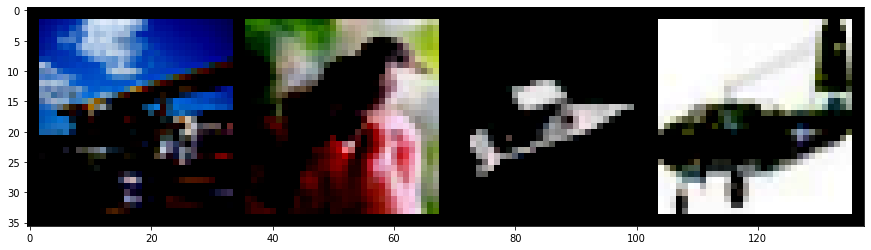

In [48]:
batch = next(iter(train_loader))

images, labels = batch

print(images.shape)
print(labels.shape)
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))

print('labels:', labels)

## Neural Network and PyTorch design

In [49]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.out = nn.Linear(in_features=84, out_features=10)

  def forward(self, t):
    #Layer 1
    t = t
    #Layer 2
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)#output shape : (6,14,14)
    #Layer 3
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)#output shape : (16,5,5)
    #Layer 4
    t = t.reshape(-1, 16*5*5)
    t = self.fc1(t)
    t = F.relu(t)#output shape : (1,120)
    #Layer 5
    t = self.fc2(t)
    t = F.relu(t)#output shape : (1, 84)
    #Layer 6/ Output Layer
    t = self.out(t)#output shape : (1,10)

    return t

network  = Network()

## Training the Neural Network
Defining a Loss Function and a Optimizer

In [50]:
optimizer = optim.Adam(network.parameters(), lr = 0.001)

In [51]:
for epoch in range(20):

  total_correct = 0
  total_loss = 0
  for batch in train_loader:
    images, labels = batch

    optimizer.zero_grad()
    preds = network(images)

    loss = F.cross_entropy(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_correct += preds.argmax(dim=1).eq(labels).sum().item()
    
  print('epoch:', epoch, "total_correct:", total_correct, "loss:", total_loss)

print('>>> Training Complete >>>')

epoch: 0 total_correct: 21401 loss: 19531.60448719561
epoch: 1 total_correct: 26726 loss: 16251.797454893589
epoch: 2 total_correct: 28813 loss: 14886.027930632234
epoch: 3 total_correct: 30428 loss: 13938.306060643867
epoch: 4 total_correct: 31341 loss: 13294.664690654725
epoch: 5 total_correct: 32008 loss: 12785.704170130659
epoch: 6 total_correct: 32599 loss: 12427.768668397795
epoch: 7 total_correct: 33147 loss: 12093.532757278066
epoch: 8 total_correct: 33376 loss: 11802.67506707157
epoch: 9 total_correct: 33796 loss: 11653.984615402645
epoch: 10 total_correct: 33878 loss: 11441.142641392446
epoch: 11 total_correct: 34199 loss: 11226.239974997123
epoch: 12 total_correct: 34473 loss: 11050.178126063955
epoch: 13 total_correct: 34732 loss: 10889.125084417887
epoch: 14 total_correct: 34883 loss: 10815.081172121485
epoch: 15 total_correct: 35114 loss: 10681.014375447658
epoch: 16 total_correct: 35153 loss: 10617.100480747235
epoch: 17 total_correct: 35269 loss: 10540.992302621016
epoc

Let's quickly save the model, we just trained.


In [52]:
PATH = './cifar_net.pth'
torch.save(network.state_dict(), PATH)

## Predictions
We will define a function to get all predictions at once.

In [53]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds

In [54]:
test_preds = get_all_preds(network, test_loader)
actual_labels = torch.Tensor(test_set.targets)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_set))

total correct: 6298
accuracy: 0.6298


## Confusion Matrix

In [60]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[707  29  78  21  21  14  16  26  57  31]
 [ 19 825  10  12   6   8  11  19  27  63]
 [ 73   8 540  82 110  83  39  51   7   7]
 [ 30  17  84 417  80 220  73  50  11  18]
 [ 32   2  89 103 571  55  63  72   7   6]
 [ 13   3  71 205  57 512  30  94   8   7]
 [  5  11  52  54  69  32 736  18  10  13]
 [ 17   7  60  55  87  76  10 673   3  12]
 [135  49  32  28   7   9  11   9 677  43]
 [ 40 161  10  33  18  16  19  37  26 640]]


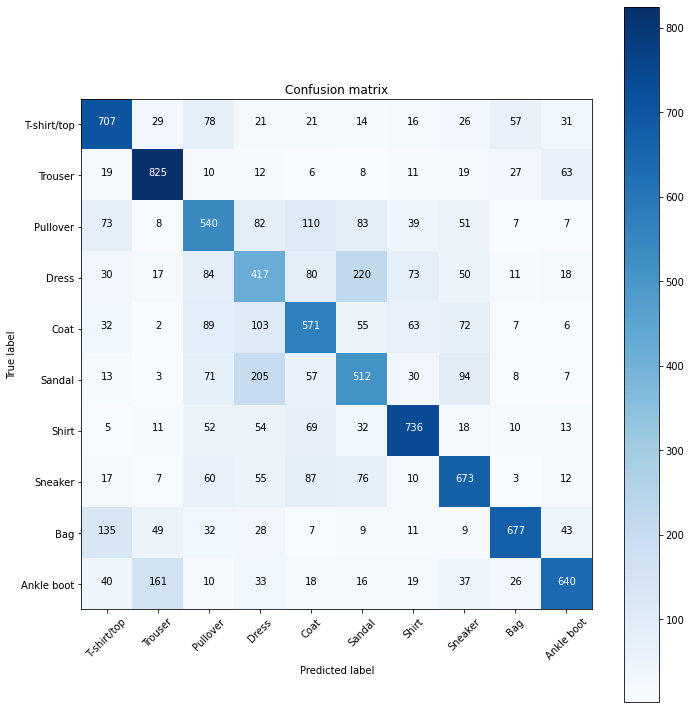

In [61]:
cm = confusion_matrix(test_set.targets, test_preds.argmax(dim=1))
names = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)